Aperiodic tilings are awesome. This is a recreation of the Penrose tilings as explained at https://preshing.com/20110831/penrose-tiling-explained/.

We'll be working with triangles, so first let's define a triangle and how to draw them, plus some utility functions for drawing stuff:

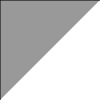

In [1]:
from collections import namedtuple
from io import BytesIO 
import cairo
import IPython.display
from enum import Enum

class T(Enum):
    NARROW = 0
    WIDE   = 1

class Tri(namedtuple('Tri', ('A', 'B', 'C', 'type'))):
    def trace(self, ctx):
        ctx.move_to(self.B.real, self.B.imag)
        ctx.line_to(self.A.real, self.A.imag)
        ctx.line_to(self.C.real, self.C.imag)
#         ctx.close_path()
    
    def draw(self, ctx):
        self.trace(ctx)
        ctx.set_source_rgb(*(self.rgba[0:-1]))
        ctx.stroke()
        self.trace(ctx)
        ctx.set_source_rgba(*self.rgba)
        ctx.fill()    
        
    @property
    def rgba(self):
        return 0, 0, 0, 0.7 - 0.3*self.type.value

def bbox(points):
    points = list(points)
    topleft  = min(p.real for p in points) + 1j*min(p.imag for p in points)
    botright = max(p.real for p in points) + 1j*max(p.imag for p in points)
    return topleft, botright

def tripoints(tris):
    for tri in tris:
        yield tri.A
        yield tri.B
        yield tri.C

def set_bbox(ctx, points, target_size=100):
    topleft, botright = bbox(points)
    longer_side = max(botright.imag - topleft.imag, botright.real - topleft.real)
    scale  = target_size / longer_side
    ctx.translate(-topleft.real*scale, -topleft.imag*scale)
    ctx.scale(target_size, target_size)
        
def show_tris(tris, size=100):
    svgio = BytesIO()
    with cairo.SVGSurface(svgio, size, size) as surface: 
        ctx = cairo.Context(surface)
        set_bbox(ctx, tripoints(tris), size)
        ctx.set_line_width(1/size)  # adapt to size
        ctx.set_line_join(cairo.LINE_JOIN_ROUND)
        for tri in tris: tri.draw(ctx)
    return IPython.display.SVG(data=svgio.getvalue())

show_tris([Tri(0+0j, 1+0j, 0+1j, T.WIDE)])

A Penrose tiling is generated by subdividing isosceles triangles -- see the explanation linked above.

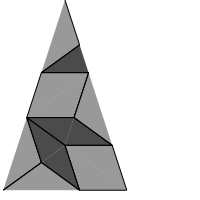

In [8]:
### import math  as m
import cmath as c

triangles = [Tri(0+0j, c.rect(1, m.pi/2 + m.pi/10), c.rect(1, m.pi/2 - m.pi/10), T.NARROW)]

phi = (1+m.sqrt(5))/2

def subdivide(triangles):
    result = []
    for tri in triangles:
        A, B, C, t = tri
        if t == T.NARROW:
            P = A + (B - A) / phi
            result += [Tri(C, P, B, T.NARROW), Tri(P, C, A, t.WIDE)]
        else:
            Q = B + (A - B) / phi
            R = B + (C - B) / phi
            result += [Tri(R, C, A, T.WIDE), Tri(Q, R, B, T.WIDE), Tri(R, Q, A, T.NARROW)]
    return result

def iterate(fn, x, times):
    res = x
    for _ in range(times):
        res = fn(res)
    return res

# GitHub does not like this when there are too many iterations,
# but you should try running it with more, it's pretty!
show_tris(iterate(subdivide, triangles, 3), size=200)